#GLOBAL PROJECT

**Postgrado en Inteligencia Artificial y Machine Learning (10ª edición)**

Leticia Cervieri Lores

#1. Carga del archivo CSV y creación del DataFrame

In [ ]:
import pandas as pd

# Carga del archivo CSV
df = pd.read_csv('/content/tweets_toxicos_fusion.csv')

# Mostrar las primeras filas del dataframe
df.head()

,text,region,dtst,label
0,Avión venezolano: ocho tripulantes coinciden e...,0,hascosva,0
1,Aquí pidiéndole consejos al amigo veneco pa so...,0,hascosva,0
2,"@oamz Cínicos desinforman con guión preparado,...",0,hascosva,0
3,@oamj No se chama dime tu 🤭🤭🤣😛😅😅,0,hascosva,0
4,Gobierno de Bélgica ustedes que albergan a Raf...,0,hascosva,0


In [ ]:
print("Dimensiones del dataframe:", df.shape)

Dimensiones del dataframe: (29761, 4)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29761 entries, 0 to 29760
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    29760 non-null  object
 1   region  29761 non-null  int64 
 2   dtst    29761 non-null  object
 3   label   29761 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 930.2+ KB


In [ ]:
# Eliminar los nulos:
df = df.dropna(subset=['text'])

# Reemplazar los valores NaN por una cadena vacía:
df.loc[:, 'text'] = df['text'].fillna('')


#2. Análisis exploratorio inicial de los datos

Distribución de las etiquetas (label) y la variable region

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

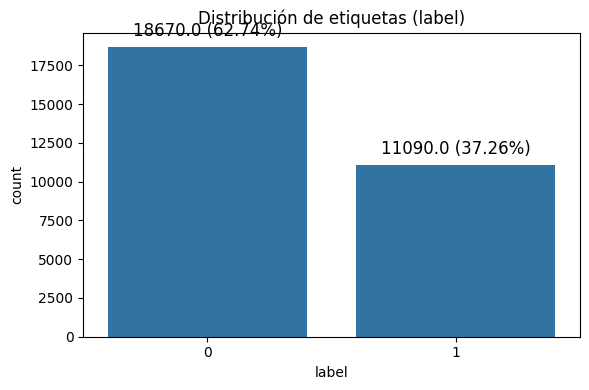

In [ ]:
# Calcular el número total de registros
total = len(df)

# Distribución de la etiqueta 'label'
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df)

# Añadir el número de registros y el porcentaje encima de cada barra
for p in ax.patches:
    count = p.get_height()  # Número de registros
    percentage = 100 * count / total  # Porcentaje
    ax.annotate(f'{count} ({percentage:.2f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribución de etiquetas (label)')
plt.tight_layout()  # Ajustar el layout
plt.show()

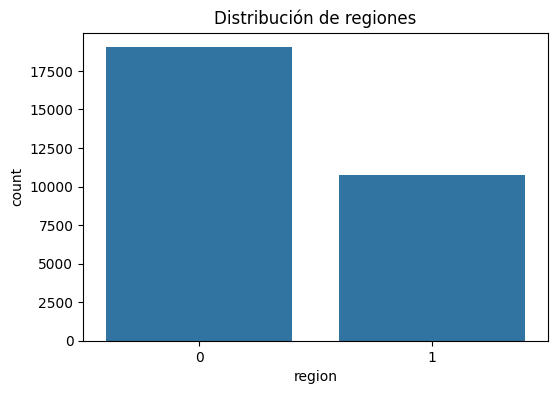

In [ ]:
# Distribución de la variable 'region'
plt.figure(figsize=(6, 4))
sns.countplot(x='region', data=df)
plt.title('Distribución de regiones')
plt.show()

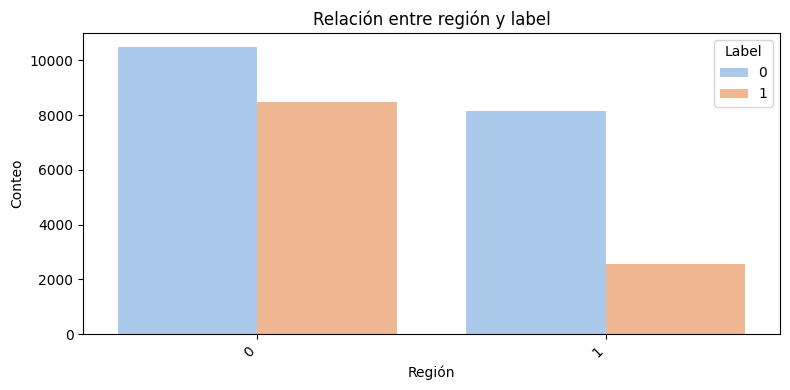

In [ ]:
import warnings

# Ignorar la advertencia FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizar la relación entre 'region' y 'label'
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='region', hue='label', palette='pastel')

# Añadir el título y etiquetas a los ejes
plt.title('Relación entre región y label')
plt.xlabel('Región')
plt.ylabel('Conteo')

# Rotar las etiquetas en el eje X si es necesario
plt.xticks(rotation=45, ha='right')

# Añadir leyenda con el título 'Label'
plt.legend(title='Label')

# Ajustar el layout para evitar solapamientos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Longitud de los tweets

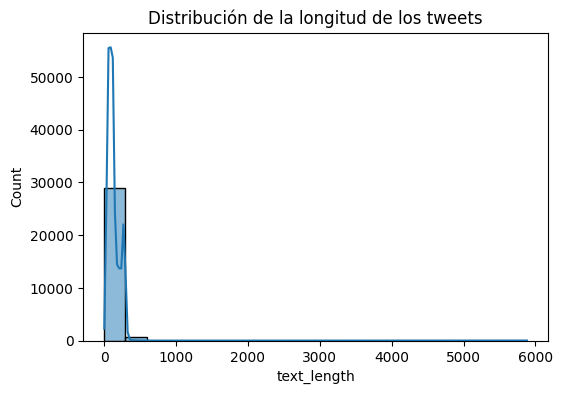

In [ ]:
# Longitud de los tweets
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(df['text_length'], bins=20, kde=True)
plt.title('Distribución de la longitud de los tweets')
plt.show()

In [ ]:
# Resumen estadístico
df['text_length'].describe()


,text_length
count,29760.000000
mean,131.508401
std,89.399196
min,3.000000
25%,72.000000
50%,111.000000
75%,174.000000
max,5883.000000


Longitud de los tweets sin outliers

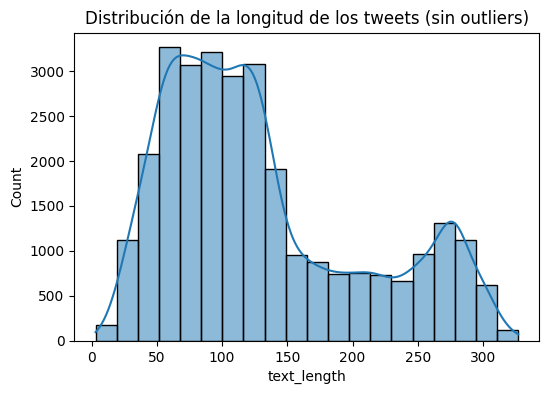

,text_length
count,29685.000000
mean,130.454977
std,76.667901
min,3.000000
25%,72.000000
50%,111.000000
75%,174.000000
max,327.000000


In [ ]:
# Calcular el IQR
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Establecer límites superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los tweets cuya longitud esté dentro de los límites
df_filtered = df[(df['text_length'] >= lower_bound) & (df['text_length'] <= upper_bound)]

# Mostrar la distribución de la longitud de los tweets después de remover outliers
plt.figure(figsize=(6, 4))
sns.histplot(df_filtered['text_length'], bins=20, kde=True)
plt.title('Distribución de la longitud de los tweets (sin outliers)')
plt.show()

# Resumen estadístico después de remover outliers
df_filtered['text_length'].describe()

In [ ]:
# Filtrar los tweets cuya longitud esté dentro de los límites (sin outliers)
df = df[(df['text_length'] >= lower_bound) & (df['text_length'] <= upper_bound)]

df.shape

(29685, 5)

#3. Preprocesamiento de los tweets

Limpieza y preprocesamiento del texto

Vamos a eliminar URLs, usuarios, caracteres especiales, y convertir el texto a minúsculas. También incluiremos la tokenización, stopwords y lematización.

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 56.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import re

# Cargar el modelo de lenguaje español
nlp = spacy.load("es_core_news_sm")

In [ ]:
# Función de preprocesamiento de texto usando spaCy
def preprocess_text_spacy(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Eliminar menciones de usuario
    text = re.sub(r'@\w+', '', text)
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-záéíóúñ\s]', '', text)
    # Procesar el texto con spaCy
    doc = nlp(text)
    # Tokenización, eliminación de stopwords y lematización
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    # Unir tokens en una cadena nuevamente
    return ' '.join(tokens)

In [ ]:
# Aplicar el preprocesamiento a los tweets
df['clean_text'] = df['text'].apply(preprocess_text_spacy)

# Ver algunas filas del dataframe después del preprocesamiento
df[['text', 'clean_text']].head()

,text,clean_text
0,Avión venezolano: ocho tripulantes coinciden e...,avión venezolano tripulante coincidir vuelo pa...
1,Aquí pidiéndole consejos al amigo veneco pa so...,pedir él consejo amigo veneco pa sobrevivir so...
2,"@oamz Cínicos desinforman con guión preparado,...",cínico desinformar guión preparado ecena nov...
3,@oamj No se chama dime tu 🤭🤭🤣😛😅😅,chamar dime
4,Gobierno de Bélgica ustedes que albergan a Raf...,gobierno bélgica alberguir rafael correa refug...


In [ ]:
# Verificar si quedan valores NaN en el DataFrame
valores_nulos = df.isnull().sum()

# Mostrar los resultados
print("Valores nulos por columna después de la operación:")
print(valores_nulos)

In [ ]:
# Verificar si quedan valores NaN en el DataFrame
valores_nulos = df.isnull().sum()

# Mostrar los resultados
print("Valores nulos por columna después de la operación:")
print(valores_nulos)

Valores nulos por columna después de la operación:
text            0
region          0
dtst            0
label           0
text_length     0
clean_text     24
dtype: int64


In [ ]:
# Eliminar los nulos:
df = df.dropna(subset=['clean_text'])

# Reemplazar los valores NaN por una cadena vacía:
df.loc[:, 'clean_text'] = df['clean_text'].fillna('')

# Guardamos datos procesados

In [ ]:
# Guardar el DataFrame preprocesado en un archivo CSV para evitar tener que volver a realizar el preprocesamiento de datos
df.to_csv('tweets_preprocesados_fusion.csv', index=False)


# 4. Análisis de los datos procesados

Distribución de la longitud de los tweets después del preprocesamiento

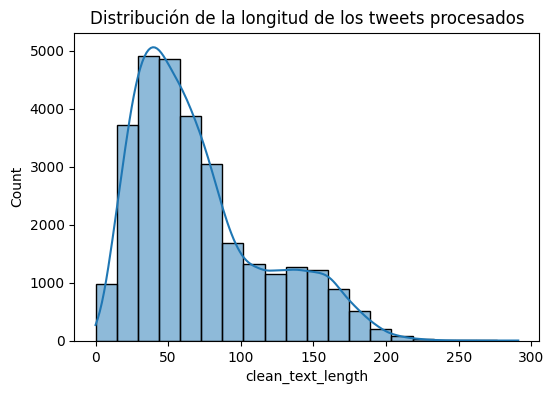

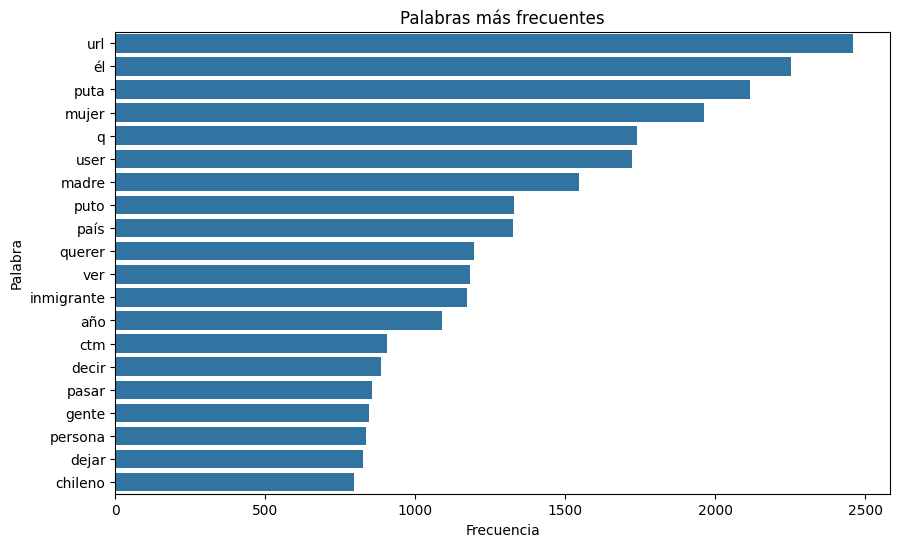

In [ ]:
# Longitud del texto limpio
df['clean_text_length'] = df['clean_text'].apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(df['clean_text_length'], bins=20, kde=True)
plt.title('Distribución de la longitud de los tweets procesados')
plt.show()

# Frecuencia de palabras
from collections import Counter

all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)

# Mostrar las 20 palabras más comunes
common_words = word_freq.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Palabra', 'Frecuencia'])

# Graficar las palabras más comunes
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=common_words_df)
plt.title('Palabras más frecuentes')
plt.show()


Nube de palabras

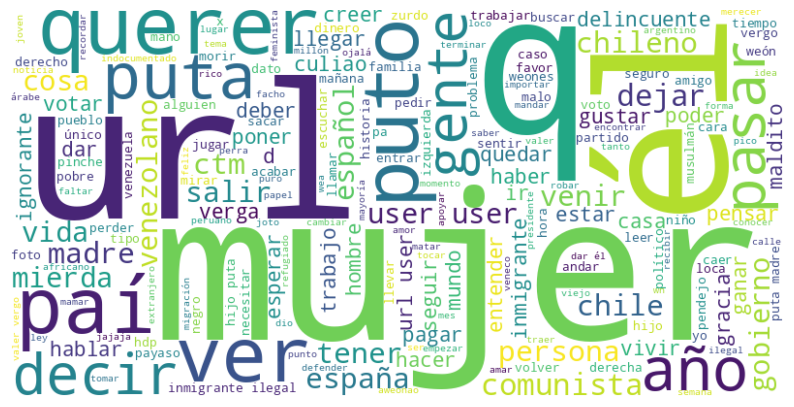

In [ ]:
from wordcloud import WordCloud

# Generar nube de palabras para todos los tweets procesados
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_text']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Análisis por región

Longitud por region

Resumen estadístico de la longitud de los tweets - Región 0:
count    18963.000000
mean       124.158256
std         73.233904
min          6.000000
25%         70.000000
50%        104.000000
75%        151.500000
max        327.000000
Name: text_length, dtype: float64




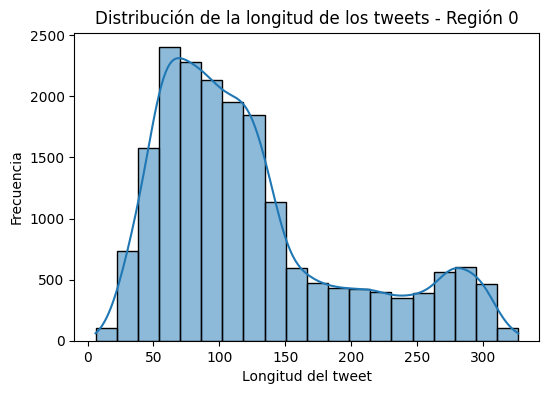

Resumen estadístico de la longitud de los tweets - Región 1:
count    10722.000000
mean       141.591401
std         81.208395
min          3.000000
25%         77.000000
50%        122.000000
75%        211.000000
max        327.000000
Name: text_length, dtype: float64




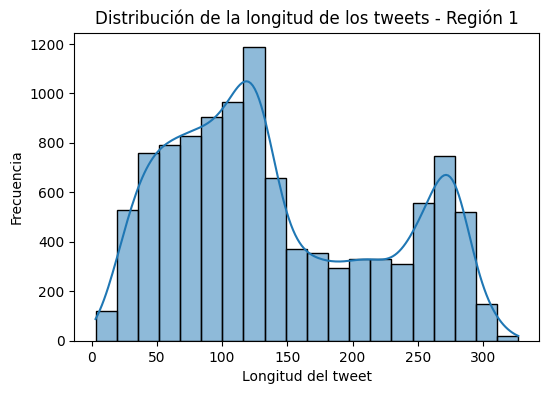

In [ ]:
# Distribución de la longitud de los tweets por región
regions = df['region'].unique()

for region in regions:
    region_df = df[df['region'] == region]

    # Resumen estadístico de la longitud de los tweets por región
    print(f'Resumen estadístico de la longitud de los tweets - Región {region}:')
    print(region_df['text_length'].describe())
    print("\n")

    # Visualizar distribución de la longitud de los tweets por región
    plt.figure(figsize=(6, 4))
    sns.histplot(region_df['text_length'], bins=20, kde=True)
    plt.title(f'Distribución de la longitud de los tweets - Región {region}')
    plt.xlabel('Longitud del tweet')
    plt.ylabel('Frecuencia')
    plt.show()

Nube de palabras por región

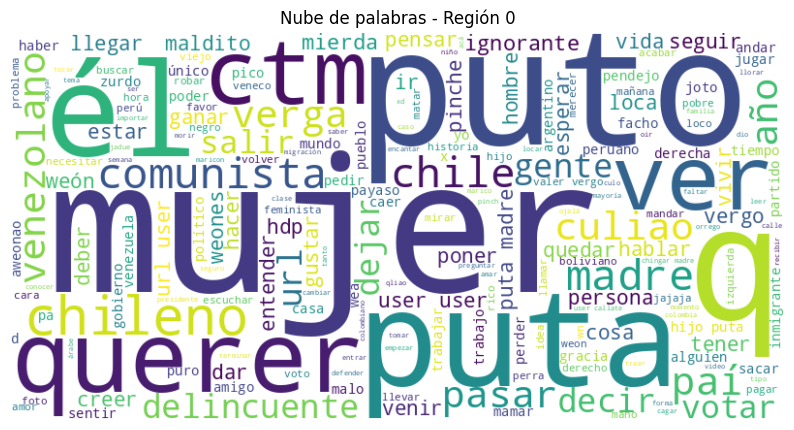

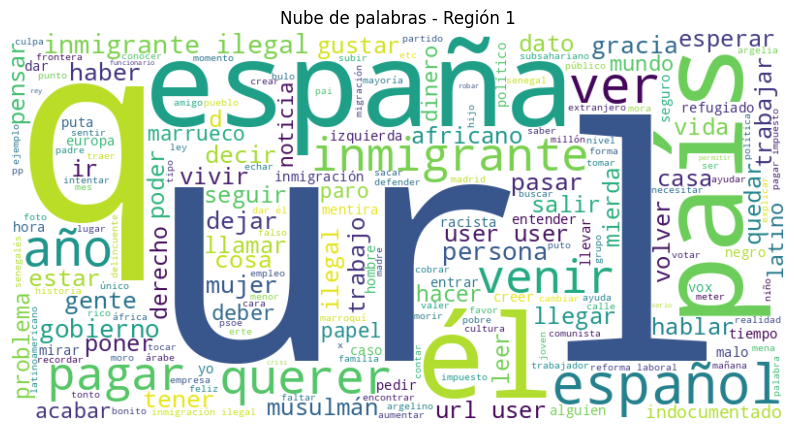

In [ ]:
# Nube de palabras por región
regions = df['region'].unique()

for region in regions:
    region_text = ' '.join(df[df['region'] == region]['clean_text'])
    wordcloud_region = WordCloud(width=800, height=400, background_color='white').generate(region_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud_region, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras - Región {region}')
    plt.show()


Palabras más frecuentes por región

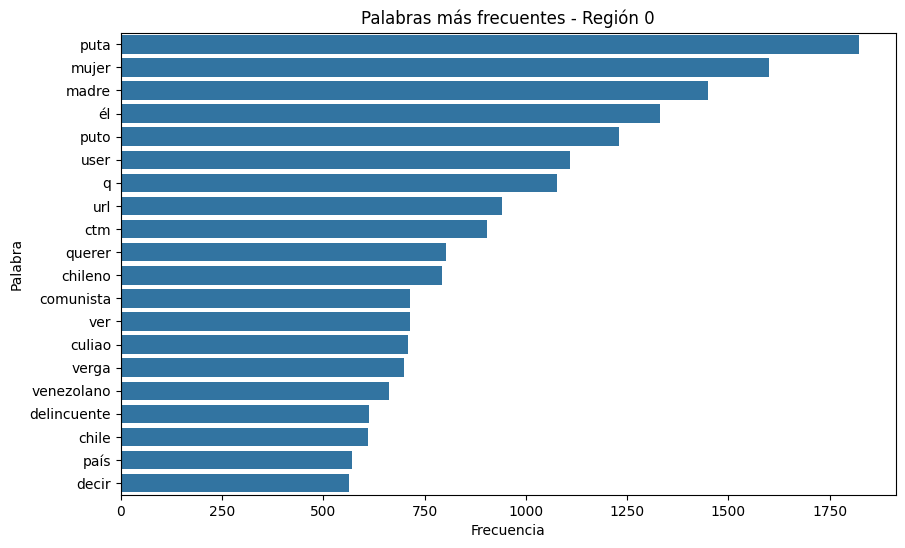

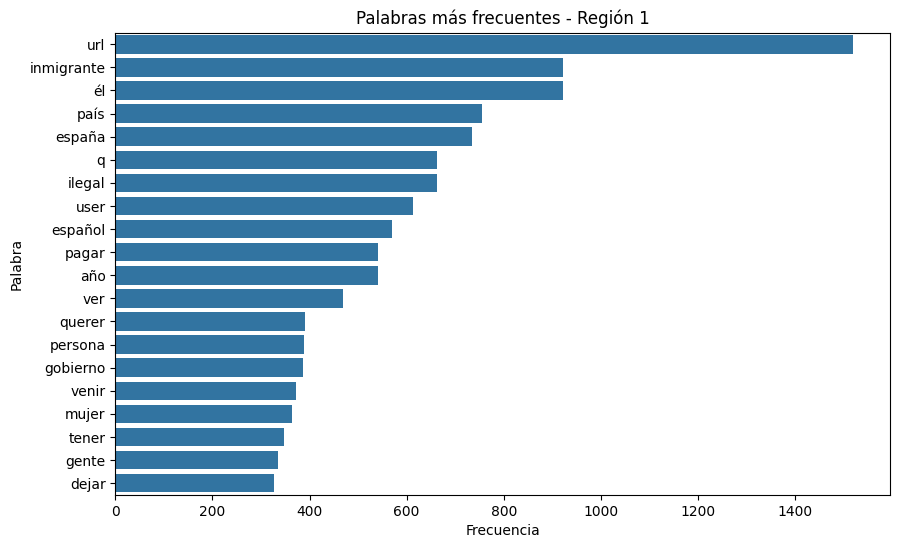

In [ ]:
from collections import Counter

# Palabras más comunes por región
for region in regions:
    region_text = ' '.join(df[df['region'] == region]['clean_text'])
    word_freq_region = Counter(region_text.split())

    # Obtener las 20 palabras más comunes
    common_words_region = word_freq_region.most_common(20)
    common_words_region_df = pd.DataFrame(common_words_region, columns=['Palabra', 'Frecuencia'])

    # Graficar las palabras más comunes en esa región
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frecuencia', y='Palabra', data=common_words_region_df)
    plt.title(f'Palabras más frecuentes - Región {region}')
    plt.show()

# Aplicación de modelos

In [ ]:
# Cargar el DataFrame preprocesado desde el archivo CSV -->si empezamos desde aquí
import pandas as pd
df = pd.read_csv('tweets_preprocesados_fusion.csv')

## Preparación de los datos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
#from imblearn.over_sampling import SMOTE
import numpy as np

In [ ]:
# Asignamos X e y
X = df['clean_text']  # Los tweets preprocesados
y = df['label']  # La clase (0 o 1)

# Dividimos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Convertimos los textos a una representación numérica (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Función de evaluación

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Predecir
    y_pred = model.predict(X_test)

    # Calcular la AUC-ROC
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Imprimir resultados
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print(f"AUC-ROC: {auc_roc}")

## Modelos de Machine Learning

In [ ]:
#Logistic Regression
logreg = LogisticRegression(class_weight='balanced', random_state=42)
print("Logistic Regression:")
evaluate_model(logreg, X_train_tfidf, X_test_tfidf, y_train, y_test)

Logistic Regression:
Matriz de Confusión:
[[3030  693]
 [ 579 1631]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      3723
           1       0.70      0.74      0.72      2210

    accuracy                           0.79      5933
   macro avg       0.77      0.78      0.77      5933
weighted avg       0.79      0.79      0.79      5933

AUC-ROC: 0.8529095156317036


In [ ]:
#Support Vector Machine
svm = SVC(class_weight='balanced', probability=True, random_state=42)
print("SVM:")
evaluate_model(svm, X_train_tfidf, X_test_tfidf, y_train, y_test)

SVM:
Matriz de Confusión:
[[3153  570]
 [ 658 1552]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3723
           1       0.73      0.70      0.72      2210

    accuracy                           0.79      5933
   macro avg       0.78      0.77      0.78      5933
weighted avg       0.79      0.79      0.79      5933

AUC-ROC: 0.8555415583452745


In [ ]:
#Random Forest
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
print("Random Forest:")
evaluate_model(rf, X_train_tfidf, X_test_tfidf, y_train, y_test)

Random Forest:
Matriz de Confusión:
[[3208  515]
 [ 767 1443]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3723
           1       0.74      0.65      0.69      2210

    accuracy                           0.78      5933
   macro avg       0.77      0.76      0.76      5933
weighted avg       0.78      0.78      0.78      5933

AUC-ROC: 0.840923244646523


## Modelo de Deep Learning

In [ ]:
!pip install transformers datasets


INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
# Cargar el DataFrame (df)
df['label'] = df['label'].astype(int)

# Dividir el dataset en entrenamiento y validación
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.2, stratify=df['label'])

In [ ]:
# Usar el tokenizer de DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenizar los textos
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

In [ ]:
# Convertir a dataset de Hugging Face
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': list(train_labels)})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': list(val_labels)})

In [ ]:
# Calcular los pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
# Cargar el modelo preentrenado DistilBERT
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [ ]:
# Mover el modelo a GPU si está disponible
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Subclase personalizada de Trainer para incluir los pesos de clase
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(device)
        # Forward del modelo
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Función de pérdida con los pesos de clase
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Definir el trainer con los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Carpeta de salida
    num_train_epochs=3,              # Número de épocas
    per_device_train_batch_size=16,  # Tamaño de batch por dispositivo
    per_device_eval_batch_size=16,   # Tamaño de batch para evaluación
    warmup_steps=500,                # Número de steps de warmup
    weight_decay=0.01,               # Tasa de decaimiento de los pesos
    logging_dir='./logs',            # Carpeta de logs
    logging_steps=10,
    evaluation_strategy="steps",     # Evaluar cada cierto número de pasos
    eval_steps=100                   # Frecuencia de evaluación
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Instanciar el WeightedTrainer en lugar del Trainer estándar
trainer = WeightedTrainer(
    model=model,                         # El modelo DistilBERT
    args=training_args,                  # Los argumentos de entrenamiento
    train_dataset=train_dataset,         # El dataset de entrenamiento
    eval_dataset=val_dataset,            # El dataset de validación
)

In [ ]:
# Entrenar el modelo
trainer.train()

Step,Training Loss,Validation Loss
100,0.688900,0.683815
200,0.652900,0.644381
300,0.605900,0.570638
400,0.572900,0.584544
500,0.597700,0.570635
600,0.538500,0.556902
700,0.575300,0.530666
800,0.582200,0.514275
900,0.476700,0.504392
1000,0.659700,0.497314


TrainOutput(global_step=4449, training_loss=0.4241788420791866, metrics={'train_runtime': 1849.4923, 'train_samples_per_second': 38.488, 'train_steps_per_second': 2.406, 'total_flos': 2357389826482176.0, 'train_loss': 0.4241788420791866, 'epoch': 3.0})

In [ ]:
# Guardar el modelo entrenado
model.save_pretrained('./distilbert_toxic_model')

In [ ]:
# Realizar predicciones
predictions = trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

In [ ]:
# Ver la matriz de confusión para los resultados
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_labels))

[[3083  640]
 [ 489 1721]]


In [ ]:
# Evaluar el rendimiento
from sklearn.metrics import classification_report
print(classification_report(val_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      3723
           1       0.73      0.78      0.75      2210

    accuracy                           0.81      5933
   macro avg       0.80      0.80      0.80      5933
weighted avg       0.81      0.81      0.81      5933



## Region

In [ ]:
# Filtrar datos por región
df_latam = df[df['region'] == 0]  # Tweets de Latinoamérica
df_spain = df[df['region'] == 1]  # Tweets de España

# Textos y etiquetas de cada región
texts_latam = df_latam['clean_text']
labels_latam = df_latam['label']

texts_spain = df_spain['clean_text']
labels_spain = df_spain['label']

In [ ]:
# Asegurarte de que no hay valores NaN en X_train y X_test
X_train = X_train.fillna('')  # Reemplazar NaN por cadena vacía
X_test = X_test.fillna('')  # Reemplazar NaN por cadena vacía

# Convertir los textos a una representación numérica (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Verificar el tamaño del resultado
print(f"Tamaño de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Tamaño de X_test_tfidf: {X_test_tfidf.shape}")

Tamaño de X_train_tfidf: (23728, 5000)
Tamaño de X_test_tfidf: (5933, 5000)


In [ ]:
# Eliminar textos con valores NaN
texts_latam = texts_latam.dropna()
texts_spain = texts_spain.dropna()

In [ ]:
# Reemplazar valores NaN con una cadena vacía
texts_latam = texts_latam.fillna('')
texts_spain = texts_spain.fillna('')

In [ ]:
# Convertir los textos a TF-IDF para los modelos de ML
X_latam_tfidf = vectorizer.transform(texts_latam)
X_spain_tfidf = vectorizer.transform(texts_spain)

In [ ]:
# Evaluar Logistic Regression por región
print("Evaluación de Logistic Regression en Latinoamérica:")
evaluate_model(logreg, X_train_tfidf, X_latam_tfidf, y_train, labels_latam)

print("Evaluación de Logistic Regression en España:")
evaluate_model(logreg, X_train_tfidf, X_spain_tfidf, y_train, labels_spain)

Evaluación de Logistic Regression en Latinoamérica:
Matriz de Confusión:
[[8338 2140]
 [1484 7001]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     10478
           1       0.77      0.83      0.79      8485

    accuracy                           0.81     18963
   macro avg       0.81      0.81      0.81     18963
weighted avg       0.81      0.81      0.81     18963

AUC-ROC: 0.8919274191580012
Evaluación de Logistic Regression en España:
Matriz de Confusión:
[[7337  799]
 [ 893 1669]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      8136
           1       0.68      0.65      0.66      2562

    accuracy                           0.84     10698
   macro avg       0.78      0.78      0.78     10698
weighted avg       0.84      0.84      0.84     10698

AUC-ROC: 0.8802366262606725


In [ ]:
# Evaluar Support Vector Machine por región
print("Evaluación de Support Vector Machine en Latinoamérica:")
evaluate_model(svm, X_train_tfidf, X_latam_tfidf, y_train, labels_latam)

print("Evaluación de Support Vector Machine n en España:")
evaluate_model(svm, X_train_tfidf, X_spain_tfidf, y_train, labels_spain)

Evaluación de Support Vector Machine en Latinoamérica:
Matriz de Confusión:
[[9490  988]
 [ 638 7847]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     10478
           1       0.89      0.92      0.91      8485

    accuracy                           0.91     18963
   macro avg       0.91      0.92      0.91     18963
weighted avg       0.92      0.91      0.91     18963

AUC-ROC: 0.9661385198248529
Evaluación de Support Vector Machine n en España:
Matriz de Confusión:
[[7859  277]
 [ 401 2161]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8136
           1       0.89      0.84      0.86      2562

    accuracy                           0.94     10698
   macro avg       0.92      0.90      0.91     10698
weighted avg       0.94      0.94      0.94     10698

AUC-ROC: 0.9705311950932508


In [ ]:
# Evaluar Random Forest por región
print("Evaluación de Random Forest en Latinoamérica:")
evaluate_model(rf, X_train_tfidf, X_latam_tfidf, y_train, labels_latam)

print("Evaluación de Random Forest en España:")
evaluate_model(rf, X_train_tfidf, X_spain_tfidf, y_train, labels_spain)

Evaluación de Random Forest en Latinoamérica:
Matriz de Confusión:
[[9996  482]
 [ 531 7954]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10478
           1       0.94      0.94      0.94      8485

    accuracy                           0.95     18963
   macro avg       0.95      0.95      0.95     18963
weighted avg       0.95      0.95      0.95     18963

AUC-ROC: 0.9802914105857851
Evaluación de Random Forest en España:
Matriz de Confusión:
[[8016  120]
 [ 289 2273]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8136
           1       0.95      0.89      0.92      2562

    accuracy                           0.96     10698
   macro avg       0.96      0.94      0.95     10698
weighted avg       0.96      0.96      0.96     10698

AUC-ROC: 0.9809108254904715


In [ ]:
# Evaluar DistilBERT en los datos de Latinoamérica y España
# Tokenizar los textos por región para DistilBERT
latam_encodings = tokenizer(list(texts_latam), truncation=True, padding=True, max_length=128)
spain_encodings = tokenizer(list(texts_spain), truncation=True, padding=True, max_length=128)

dataset_latam = Dataset.from_dict({'input_ids': latam_encodings['input_ids'], 'attention_mask': latam_encodings['attention_mask'], 'labels': list(labels_latam)})
dataset_spain = Dataset.from_dict({'input_ids': spain_encodings['input_ids'], 'attention_mask': spain_encodings['attention_mask'], 'labels': list(labels_spain)})

print("Evaluación de DistilBERT en Latinoamérica:")
predictions_latam = trainer.predict(dataset_latam)
pred_labels_latam = np.argmax(predictions_latam.predictions, axis=1)
print(confusion_matrix(labels_latam, pred_labels_latam))
print(classification_report(labels_latam, pred_labels_latam))

print("Evaluación de DistilBERT en España:")
predictions_spain = trainer.predict(dataset_spain)
pred_labels_spain = np.argmax(predictions_spain.predictions, axis=1)
print(confusion_matrix(labels_spain, pred_labels_spain))
print(classification_report(labels_spain, pred_labels_spain))

Evaluación de DistilBERT en Latinoamérica:


[[8846 1632]
 [2266 6219]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82     10478
           1       0.79      0.73      0.76      8485

    accuracy                           0.79     18963
   macro avg       0.79      0.79      0.79     18963
weighted avg       0.79      0.79      0.79     18963

Evaluación de DistilBERT en España:


[[7673  463]
 [1344 1218]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      8136
           1       0.72      0.48      0.57      2562

    accuracy                           0.83     10698
   macro avg       0.79      0.71      0.73     10698
weighted avg       0.82      0.83      0.82     10698

